In [1]:
pip install keras_applications 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, MaxPool2D
from keras.layers.core import Lambda
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
from tensorflow.keras import datasets, layers, models, losses
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *
#from keras.utils import multi_gpu_model
from matplotlib import pyplot as plt
from keras.models import load_model
import keras.backend as K
from keras.layers.core import Lambda
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.inception_v3 import InceptionV3 
from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import VGG16
#from keras.applications.resnet50 import ResNet50
from keras_applications.resnet import ResNet50
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
import os
from keras.layers import *

In [9]:
def GC_Block(inputs,ratio = 16):
    shape=K.int_shape(inputs)
    ch = shape[3]
    conv =  Conv2D(1,1, padding='same') (inputs)
    print(conv.shape)
    d = shape[1]*shape[2]
    reshpe = tf.keras.layers.Reshape((1,1,d),input_shape=(1,1,shape[1],shape[2]))(conv)
    print(reshpe.shape)
    sm = tf.keras.layers.Softmax()(reshpe)
    print(sm.shape)


    reshpe = tf.keras.layers.Reshape((shape[3],d),input_shape=(shape[1],shape[2],shape[3]))(inputs)
    print(reshpe.shape)
    mul = tf.keras.layers.Dot(axes=-1)([reshpe,sm])
  #mul = tf.keras.layers.Attention(use_scale=False, score_mode="dot")([reshpe,sm])
    new_shape = K.int_shape(mul)
    print(new_shape)
    reshpe = tf.keras.layers.Reshape((1,1,new_shape[1]),input_shape=(new_shape[1],new_shape[2],new_shape[3]))(mul)
    print(reshpe.shape)
    x = Conv2D(ch//ratio,1)(reshpe)
  #print(x.shape)
    x = tf.keras.layers.LayerNormalization() (x)
  #print(x.shape)
    x = tf.keras.layers.ReLU()(x)
    x = Conv2D(ch,1, padding='same')(x)
  #print(x.shape)
    gc_attend = tf.keras.layers.Add()([inputs, x])
  #print(gc_attend.shape)
    return gc_attend

In [10]:
def smooth_curve(points, factor=0.6):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points    
   
def plotmodel(history,name):
    
    acc = history.history['acc']
    #val_acc = history.history['val_acc']
    loss = history.history['loss']
    #val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1) 
    
    plt.figure(1)                  
    plt.plot(epochs,smooth_curve(acc))
    #plt.plot(epochs,smooth_curve(val_acc))
    plt.ylabel('acc')
    plt.xlabel('epoch')
    #plt.legend(['train_acc', 'val_acc'], loc='upper left')
    plt.legend(['train_acc'], loc='upper left')
    plt.savefig('acc_'+name+'gc.png')
    
    plt.figure(2)
    plt.plot(epochs,smooth_curve(loss))
    #plt.plot(epochs,smooth_curve(val_loss))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    #plt.legend(['train_loss', 'val_loss'], loc='upper right')
    plt.legend(['train_loss'], loc='upper right')
    plt.savefig('loss_'+name+'gc.png')
    
def get_base_model(model_name,image_size):
    if model_name =='vgg16':
        base_model=VGG16              (include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='resnet50':
        base_model=tf.keras.applications.ResNet50           (include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='xception':
        base_model=Xception           (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='densenet121':    #done acc = 55% epochs:30
        base_model=DenseNet121       (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='mobilenet0.75': 
        base_model=MobileNet         (include_top=False,weights='imagenet',alpha=0.75,input_shape=(image_size,image_size,3))
    if model_name =='mobilenet1.0': 
        base_model=MobileNet         (include_top=False,weights='imagenet',alpha=1.0,input_shape=(image_size,image_size,3))
    if model_name =='mobilenetv2':
        base_model=MobileNetV2      (include_top=False,weights='imagenet',alpha=1.0,input_shape=(image_size,image_size,3))
    if model_name =='inceptionv3':   
        base_model=InceptionV3       (include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='inceptionv2':
        base_model=tf.keras.applications.InceptionResNetV2 (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    return base_model

def train_model(model,dataset,image_size,batch_size,save_name,lr1,lr2,Epochs1,Epochs2):
    
    dataParam={'messidor': [960,240,2,'Messidor_Binary_512/train',
                            'Messidor_Binary_512/test'],
               'kaggle': [30000,5126,5,'./data/kaggle/train','./data/kaggle/valid'],
               'DDR':   [9851,2503,5,'./data/DDR/train','./data/DDR/valid']} 
    
    train_num,valid_num,classes,train_dir,test_dir = dataParam[dataset]
    
    train=ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=90)          
    valid = ImageDataGenerator()
    train_data=train.flow_from_directory(train_dir,
                                         target_size=(image_size,image_size),
                                         shuffle = True,
                                         batch_size=batch_size)
    valid_data=valid.flow_from_directory(test_dir,
                                         target_size=(image_size,image_size),
                                         shuffle = False,
                                         batch_size=batch_size)

    lr_decay=ReduceLROnPlateau(monitor='loss', factor=0.8, patience=3, verbose=1)
    #save_model=ModelCheckpoint('new/'+save_name+'{epoch:02d}.h5', monitor='val_loss',period=10)
    
    filepath = "resnet50+GC_Block.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='acc',verbose=1, save_best_only=True, mode='max')

    for layer in base_model.layers:
        layer.trainable = False   
        
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr1,decay=0.00001),loss=loss_fun,metrics=['acc'])
    model.fit(train_data,
                        steps_per_epoch=train_num/batch_size,
                        epochs=Epochs1, 
                        workers=2,
                        callbacks=[lr_decay,checkpoint])   
    
    for layer in base_model.layers:
        layer.trainable = True
        
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr2,decay=0.00001),loss=loss_fun,metrics=['acc'])
    history=model.fit(train_data,
                        steps_per_epoch=train_num/batch_size,
                        epochs=Epochs2,
                        workers=2,
                        callbacks=[lr_decay,checkpoint])
    
    score = model.evaluate(valid_data,batch_size = 64)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return history,model,valid_data

In [11]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"    
loss_fun= 'binary_crossentropy'  
gpu_num=1
k=3
lr1=0.005
lr2=0.0001
batch_size= 16
image_size=512
classes=2

base_model=get_base_model('resnet50',image_size)  
base_in=base_model.input
base_out=base_model.output

shape = K.int_shape(base_out)
channel_val = shape[3]/2
#red_feat = tf.keras.layers.Conv2D(channel_val,1,padding='same')(base_out)
x=GC_Block(base_out)


shape=K.int_shape(x)  
x=GlobalAveragePooling2D()(x)
out=Dense(classes,activation='softmax')(x)

parallel_model=keras.Model(base_model.input,out)
parallel_model.summary()

(None, 16, 16, 1)
(None, 1, 1, 256)
(None, 1, 1, 256)
(None, 2048, 256)
(None, 2048, 1, 1)
(None, 1, 1, 2048)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                  

                                                                                                  
 conv2_block2_add (Add)         (None, 128, 128, 25  0           ['conv2_block1_out[0][0]',       
                                6)                                'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, 128, 128, 25  0           ['conv2_block2_add[0][0]']       
                                6)                                                                
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 128, 128, 64  16448       ['conv2_block2_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv2_blo

                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 64, 64, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 64, 64, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 64, 64, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
                                                                                                  
 conv3_block2_out (Activation)  (None, 64, 64, 512)  0           ['conv3_block2_add[0][0]']       
          

                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 32, 32, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 32, 32, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_add (Add)         (None, 32, 32, 1024  0           ['conv4_block1_0_bn[0][0]',      
                                )                                 'conv4_block1_3_bn[0][0]']      
          

 conv4_block4_2_relu (Activatio  (None, 32, 32, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 32, 32, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 32, 32, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block4_add (Add)         (None, 32, 32, 1024  0           ['conv4_block3_out[0][0]',       
          

                                                                                                  
 conv5_block1_2_relu (Activatio  (None, 16, 16, 512)  0          ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, 16, 16, 2048  2099200     ['conv4_block6_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block1_3_conv (Conv2D)   (None, 16, 16, 2048  1050624     ['conv5_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv5_blo

                                                                                                  
 softmax (Softmax)              (None, 1, 1, 256)    0           ['reshape[0][0]']                
                                                                                                  
 dot (Dot)                      (None, 2048, 1, 1)   0           ['reshape_1[0][0]',              
                                                                  'softmax[0][0]']                
                                                                                                  
 reshape_2 (Reshape)            (None, 1, 1, 2048)   0           ['dot[0][0]']                    
                                                                                                  
 conv2d_1 (Conv2D)              (None, 1, 1, 128)    262272      ['reshape_2[0][0]']              
                                                                                                  
 layer_nor

In [12]:
history,model,valid_data=train_model(parallel_model,
                                     'messidor',
                                     image_size,
                                     batch_size,
                                     'resnet50',
                                     lr1,lr2,1,90)

Found 960 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


2022-05-09 12:55:09.214708: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


60/60 [==============================] - ETA: 0s - loss: 1.2529 - acc: 0.6115
Epoch 1: acc improved from -inf to 0.61146, saving model to resnet50+GC_Block.hdf5
60/60 [==============================] - 38s 526ms/step - loss: 1.2529 - acc: 0.6115 - lr: 0.0050
Epoch 1/90
60/60 [==============================] - ETA: 0s - loss: 0.5115 - acc: 0.7406
Epoch 1: acc improved from 0.61146 to 0.74063, saving model to resnet50+GC_Block.hdf5
60/60 [==============================] - 44s 611ms/step - loss: 0.5115 - acc: 0.7406 - lr: 1.0000e-04
Epoch 2/90
60/60 [==============================] - ETA: 0s - loss: 0.3907 - acc: 0.8260
Epoch 2: acc improved from 0.74063 to 0.82604, saving model to resnet50+GC_Block.hdf5
60/60 [==============================] - 38s 614ms/step - loss: 0.3907 - acc: 0.8260 - lr: 1.0000e-04
Epoch 3/90
60/60 [==============================] - ETA: 0s - loss: 0.3274 - acc: 0.8635
Epoch 3: acc improved from 0.82604 to 0.86354, saving model to resnet50+GC_Block.hdf5
60/60 [=====

60/60 [==============================] - ETA: 0s - loss: 0.1133 - acc: 0.9563
Epoch 31: acc did not improve from 0.97292
60/60 [==============================] - 40s 656ms/step - loss: 0.1133 - acc: 0.9563 - lr: 8.0000e-05
Epoch 32/90
60/60 [==============================] - ETA: 0s - loss: 0.0772 - acc: 0.9708
Epoch 32: acc did not improve from 0.97292
60/60 [==============================] - 38s 610ms/step - loss: 0.0772 - acc: 0.9708 - lr: 8.0000e-05
Epoch 33/90
60/60 [==============================] - ETA: 0s - loss: 0.1038 - acc: 0.9552
Epoch 33: acc did not improve from 0.97292
60/60 [==============================] - 42s 657ms/step - loss: 0.1038 - acc: 0.9552 - lr: 8.0000e-05
Epoch 34/90
60/60 [==============================] - ETA: 0s - loss: 0.0742 - acc: 0.9740
Epoch 34: acc improved from 0.97292 to 0.97396, saving model to resnet50+GC_Block.hdf5
60/60 [==============================] - 42s 681ms/step - loss: 0.0742 - acc: 0.9740 - lr: 8.0000e-05
Epoch 35/90
60/60 [=========

Epoch 63/90
60/60 [==============================] - ETA: 0s - loss: 0.0106 - acc: 0.9979
Epoch 63: acc did not improve from 0.99896
60/60 [==============================] - 39s 642ms/step - loss: 0.0106 - acc: 0.9979 - lr: 3.2768e-05
Epoch 64/90
60/60 [==============================] - ETA: 0s - loss: 0.0088 - acc: 0.9979
Epoch 64: ReduceLROnPlateau reducing learning rate to 2.6214399258606137e-05.

Epoch 64: acc did not improve from 0.99896
60/60 [==============================] - 38s 620ms/step - loss: 0.0088 - acc: 0.9979 - lr: 3.2768e-05
Epoch 65/90
60/60 [==============================] - ETA: 0s - loss: 0.0087 - acc: 0.9979
Epoch 65: acc did not improve from 0.99896
60/60 [==============================] - 41s 649ms/step - loss: 0.0087 - acc: 0.9979 - lr: 2.6214e-05
Epoch 66/90
60/60 [==============================] - ETA: 0s - loss: 0.0177 - acc: 0.9990
Epoch 66: acc did not improve from 0.99896
60/60 [==============================] - 38s 614ms/step - loss: 0.0177 - acc: 0.999

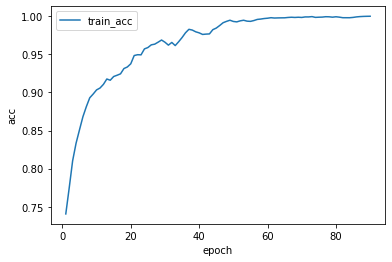

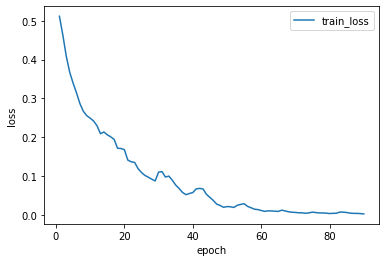

In [13]:
plotmodel(history,'resnet50')         

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

Y_pred = model.predict(valid_data, 240 // 4)
#print(Y_pred.shape)
#print(type(Y_pred))
print(valid_data.classes)  
print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
#print(y_pred)
print('Confusion Matrix')
matrix = confusion_matrix(valid_data.classes, y_pred)

print(confusion_matrix(valid_data.classes, y_pred))
print('Classification Report')
target_names = ['non-referable', 'referable']
print(classification_report(valid_data.classes, y_pred, target_names=target_names))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[9.90078211e-01 9.92183201e-03]
 [9.99999881e-01 9.20642549e-08]
 [1.00000000e+00 8.12143495e-12]
 [1.00000000e+00 1.15339194e-09]
 [1.00000000e+00 9.74065412e-11]
 [1.00000000e+00 1.29258167e-11]
 [1.00000000e+00 1.10909246e-08]
 [7.12238997e-02 9.28776085e-01]
 [9.99999762e-01 2.09551942e-07]
 [9.99990106e-01 9.91777961e-06]
 [1.00000000e+00 4.27919158e-11]
 [9.99999642e-01 3.19596467e-07]
 [8.71860623e-01 1.28139317e-01]
 [1.00000000e+00 2.02048280e-08]
 [1.00000000e+00 7.60010197e-12]
 [9.98353362e-01 

Text(69.0, 0.5, 'Truth')

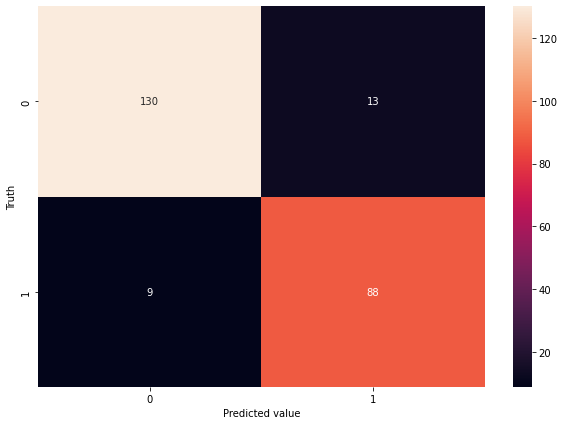

In [15]:
plt.figure(figsize = (10,7))
sn.heatmap(matrix,annot=True,fmt='d')
plt.xlabel('Predicted value')
plt.ylabel('Truth')   

In [16]:
pip install plot-metric

Note: you may need to restart the kernel to use updated packages.


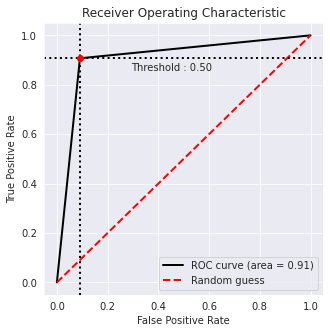

In [17]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
y_true = valid_data.classes
y_probas = y_pred
bc = BinaryClassification(y_true, y_probas, labels=['non-referable', 'referable'])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()